In [10]:
import sys
import math
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
import logging
import os
from scipy import integrate, signal
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
from scipy.signal import savgol_filter
import tables
import utils
from utils import hd_kernel, MMD
from tqdm import tqdm # to display a loading bar for iterables
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt


LOG = logging.getLogger(os.path.basename(''))

SF = 256 # sampling rate
SECONDS = 1 # number of seconds per sample
SEG_LENGTH = SF*SECONDS
BANDS = [(1,4), (4,8), (8,12), (12,30)]
DELAY  = 1

lraccs  = []
mmdaccs = []
lraccs_down  = []

def encodeLBP(X, prev):
    return None

def main(emb = 3, p=1, buff=40, kernel_name="hd"):
    
    EMBDEM = emb
    num = 1
    acc = 0
    trainData   = []
    trainLabels = []
    valData     = []
    valLabels   = []
    prev = None

    
    # various kernels to use in the MMD calculation
    if kernel_name == "rbf":
        kernel = rbf_kernel
    elif kernel_name == "laplacian":
        kernel = laplacian_kernel
    elif kernel_name == "linear":
        kernel = linear_kernel
    elif kernel_name == "polynomial":
        kernel = polynomial_kernel
    elif kernel_name == "hd":
        kernel = hd_kernel
    
    LOG.info("Using kernel: {}".format(kernel_name))
    
    # directory where we save graphs of MMD
    dirname = "../temp/psd/{}".format(kernel_name)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
    # go through all subjects eeg readings
    with tables.open_file("../input/physionet/eeg_data_temples2.h5") as h5_file:
        for node in h5_file.walk_nodes("/", "CArray"):
            LOG.info("Processing: {}".format(node._v_name))
            
            if len(node.attrs.seizures) != 1:
                continue
            
            data = node.read()
            seizures = node.attrs.seizures
            X, y = data[:,:-1], data[:,-1]
            #print(y.shape)
            start = np.min(np.where(y > 0)[0])
            stop = np.max(np.where(y > 0)[0])

            buff_mins = buff
            minv = max(0, start-(buff_mins*60*SF))
            maxv = min(X.shape[0], stop+(buff_mins*60*SF))
            data = data[minv:maxv,:]
            X = X[minv:maxv,:]
            y = y[minv:maxv]
            
            sos = signal.butter(3, 50, fs=SF, btype="lowpass", output="sos")
            #print(X.shape)
            X = signal.sosfilt(sos, X, axis=1) # n x c eeg readings (n features, c channels)
            Z = [] # feature matrix ()
            q = [] # labels for each data point (n x 1)
            moments = []
            perms   = []
            
            syms = [1,-1]
            codes = np.random.choice(syms, (SEG_LENGTH-1, X.shape[1])) # num_channels X SEG_LENGTH
            last = None

            for ix in range(SEG_LENGTH, X.shape[0], SEG_LENGTH):
                segment = X[ix-SEG_LENGTH:ix, :] # make segment X channel
                
                # For each element 
                lbp = np.diff(segment, axis=0)
                #lbp = np.array(segment[:,:-1] < segment[:,1:], dtype=int)
                
#                 if last is None:
#                     lbp = np.hstack( (np.zeros((segment.shape[0],1)), lbp) )
#                 else:
#                     lbp = np.hstack( (np.array(last < segment[:,0].reshape(-1,1), dtype=int), lbp) )
                
                lbp[lbp >= 0] = 1
                lbp[lbp < 0]  = -1
                #last = segment[:, -1].reshape(-1,1)
                
                # element-wise multiplication
                # sum across channels
                W = np.sum(lbp*codes, axis=1)

                Z.append(W)
                q.append(np.any(y[ix-SEG_LENGTH:ix]))
            
            Z = np.vstack(Z) # make each element in list into a row in this numpy array
            y = np.array(q)
            K = kernel(Z)
            #print(K)
            
            if num == 1:
                valData = Z
                valLabels = q
            elif num <= p:
                valData = np.vstack((valData, Z))
                valLabels = np.append(valLabels, y)
            elif not np.any(trainData):
                trainData = Z
                trainLabels = y
            else:
                trainData = np.vstack((trainData, Z))
                trainLabels = np.append(trainLabels, y)
            
            mmd, mmd_corr = MMD(Z, K)

            # mmd = mmd[200:-200]
            # mmd_corr = mmd_corr[200:-200]
            cut = 10
            
            # get bounds on range for which a seizure occured
            seiz_lb = np.min(np.where(y > 0)[0])
            seiz_ub = np.max(np.where(y > 0)[0])
            
            # mark bounds on mmd range to analyze
            lower_cut = cut # lower cut
            upper_cut = len(mmd)-cut # upper cut

            mmd_max    = np.min(mmd[lower_cut:upper_cut])
            mmd_maxidx = np.argmin(mmd[lower_cut:upper_cut]) + lower_cut
            
            mmdcor_max    = np.min(mmd_corr[lower_cut:upper_cut])
            mmdcor_maxidx = np.argmin(mmd_corr[lower_cut:upper_cut]) + lower_cut
            
            error = 0
            if seiz_ub > mmdcor_maxidx:
                error = -SECONDS*max(0, seiz_lb - mmd_maxidx)
            else:
                error = SECONDS*(mmd_maxidx - seiz_ub)
                
            if error == 0:
                acc += 1
            
            print("Plot {} - Embedding Perm {} Error: {:.4f} sec.".format(num, emb, error))
            num += 1
            
            clf = LogisticRegression(random_state=0).fit(Z, q)
            print("LR accuracy on training:", clf.score(Z, q))
            
            Z_down, q_down = utils.downSample(Z, q)
            clf = LogisticRegression(random_state=0).fit(Z_down, q_down)
            print("LR accuracy on downsampled training:", clf.score(Z, q))
            
            # Plotting MMD
            x_axis = range(1, len(mmd)+1, 2)
            x_axis = [2*x for x in x_axis]
#             print(mmd.shape)
#             print(Z.shape)
            
            plt.figure(figsize=(20,6))
            plt.plot(mmd, label="MMD")
            plt.plot(mmd_corr, label="MMD (Corrected)")
                
            plt.axvline(x=lower_cut, linewidth=2, color="red")
            plt.axvline(x=upper_cut, linewidth=2, color="red")
            
            plt.axvline(x=seiz_lb, linewidth=2, color="green")
            plt.axvline(x=seiz_ub, linewidth=2, color="green")
            
            plt.plot(mmd_maxidx, mmdcor_max, marker="+", markersize=30, color="black")
            plt.plot(mmdcor_maxidx, mmdcor_max, marker="x", markersize=30, color="orange")
            
            locs, labels = plt.xticks()
            plt.xticks(locs, 2*locs)
            plt.xlim(-cut, len(mmd_corr) + cut)
           
            plt.savefig("{}/{}_mmd.png".format(dirname, node._v_name))
            
            for i, c in enumerate(BANDS):
                plt.close()
                
                plt.figure(figsize=(20,6))
                plt.xlabel("Time (s)")
                plt.ylabel("MMD")
                plt.title("MMD Over Time")
                
                plt.plot(mmd, label="MMD")
                plt.plot(mmd_corr, label="MMD (Corrected)")
                smooth_power = savgol_filter(Z[:, i], 15, 2)
                plt.plot(smooth_power, label="({}) Rel. Bandpower".format(", ".join(str(x) for x in c)))
                plt.legend(loc="upper left")

                plt.axvline(x=lower_cut, linewidth=2, color="red")
                plt.axvline(x=upper_cut, linewidth=2, color="red")

                plt.axvline(x=seiz_lb, linewidth=2, color="green")
                plt.axvline(x=seiz_ub, linewidth=2, color="green")

                plt.plot(mmd_maxidx, mmdcor_max, marker="+", markersize=30, color="black")
                plt.plot(mmdcor_maxidx, mmdcor_max, marker="x", markersize=30, color="orange")

                locs, labels = plt.xticks()
                plt.xticks(locs, 2*locs)
                plt.xlim(-50, len(mmd_corr) + 50)
                plt.show()
            
            plt.close()
        
        acc /= num
        mmdaccs.append(acc)
        print("Total accuracy: {}".format(acc))
        
        # Here we use first p subject as validation and everything else as training
        clf = LogisticRegression(random_state=0).fit(trainData, trainLabels)
        lracc = clf.score(valData, valLabels)
        lraccs.append(lracc)
        print("LR accuracy on validation:", lracc)
        
        train_data_down, train_labels_down = utils.downSample(trainData, trainLabels)
        val_data_down, val_labels_down     = utils.downSample(valData, valLabels)
        
        clf = LogisticRegression(random_state=0).fit(train_data_down, train_labels_down)
        lracc_down = clf.score(val_data_down, val_labels_down)
        lraccs_down.append(lracc_down)
        print("LR accuracy on downsampled validation:", lraccs_down)

def ordinal_patterns(ts, embdim, embdelay):
    # ts is passed in as n x 2; n features, 2 channels
    num_permus = math.factorial(embdim)
    total = len(ts) - embdelay * (embdim - 1)
    lst = []
    # fix so that we do calculation along single dimension
    # Number of vectors is T - t(D - 1)
    for i in range(len(ts) - embdelay * (embdim - 1)):
        #print(ts[i:(embdim+i)])
        
        sorted_index_array = list(np.argsort(ts[i:(embdim+i)]))
        #print(sorted_index_array)
        lst.append(sorted_index_array)
        
    lst = np.array(lst)
    element, freq = np.unique(lst, return_counts = True, axis=0)
    freq = list(freq)
    
    # Fix missing entries
    if len(freq) != num_permus:
        for i in range(num_permus-len(freq)):
            freq.append(0)
    
    freq = [x/total for x in freq]
    return freq 
    
def s_entropy(freq_list, d):

    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    
    for freq in freq_list:
        sh_entropy += freq * np.log2(freq)
        
    sh_entropy = -sh_entropy
    
    return(sh_entropy)
            
def compute_band_relpower(X):
    freqs, psd = signal.welch(X, SF, axis=0)
    freq_res = freqs[1] - freqs[0]
    total_power = integrate.simps(psd, dx=freq_res, axis=0)

    where = total_power <= 1e-5
    total_power[where] = -1

    band_relpower = []
    for lb, ub in BANDS:
        idx = np.logical_and(freqs >= lb, freqs < ub)
        band_power = integrate.simps(psd[idx,:], dx=freq_res, axis=0)
        relpow = band_power / total_power
        relpow[where] = 0
        band_relpower.append(relpow)
    
    return np.concatenate(band_relpower)

100%|██████████| 158/158 [00:00<00:00, 5988.40it/s]
/home/darylnak/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Plot 1 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 1.0
LR accuracy on downsampled training: 0.8427672955974843


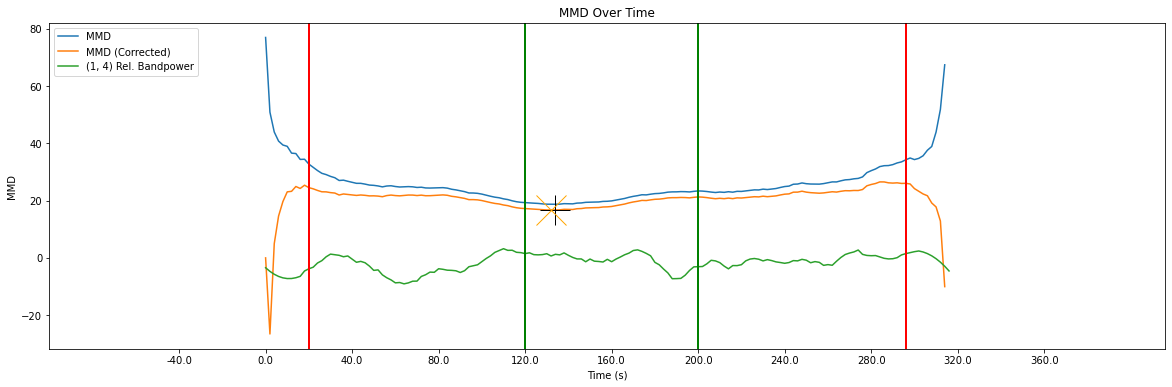

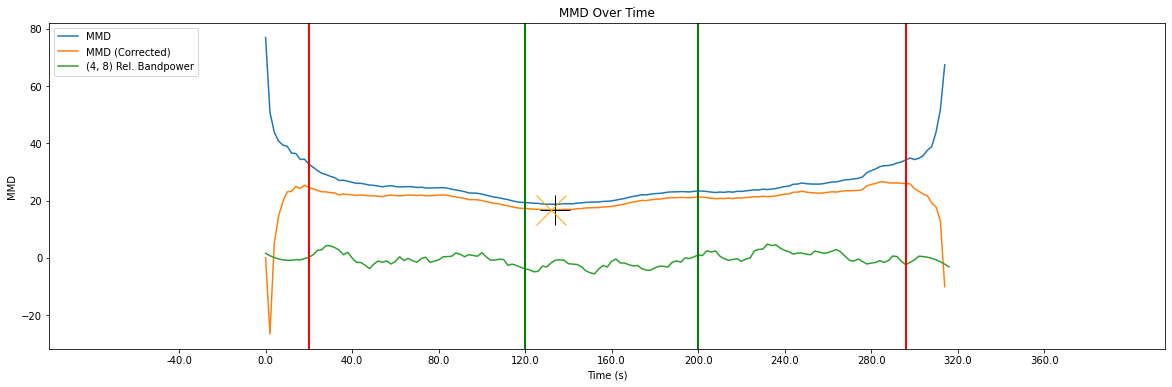

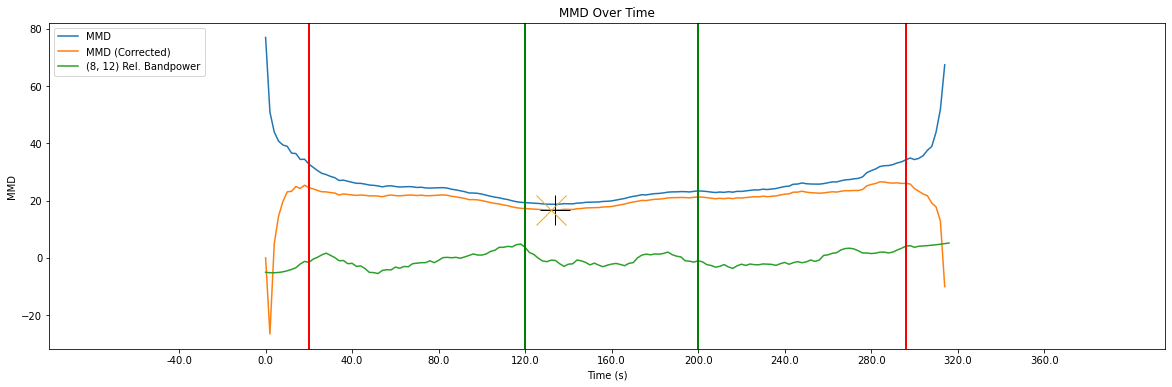

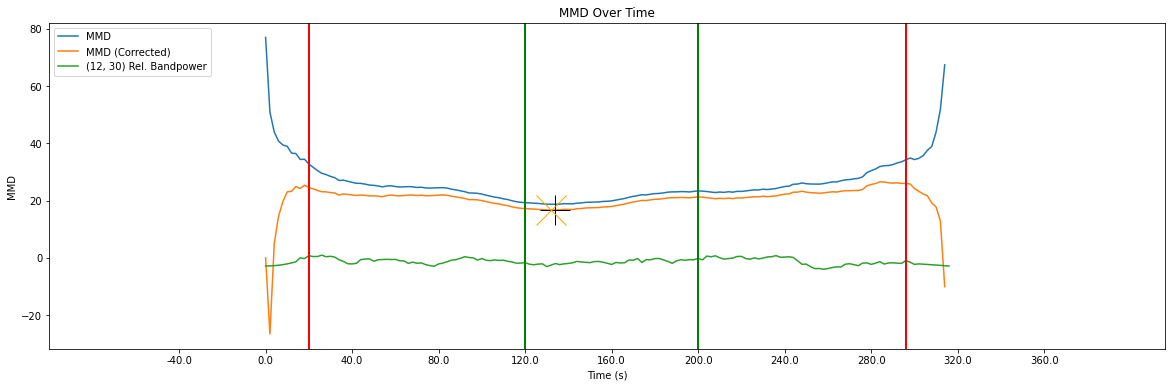

100%|██████████| 145/145 [00:00<00:00, 4579.11it/s]
/home/darylnak/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Plot 2 - Embedding Perm 3 Error: -6.0000 sec.
LR accuracy on training: 1.0
LR accuracy on downsampled training: 0.8767123287671232


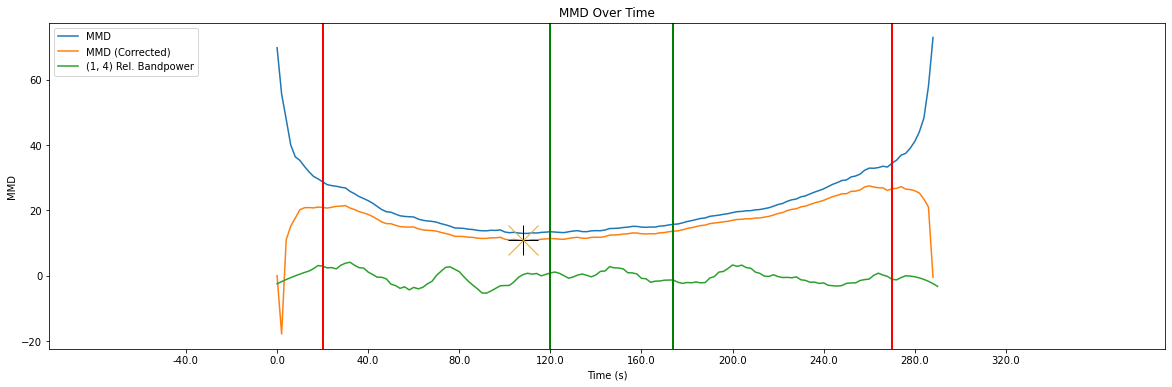

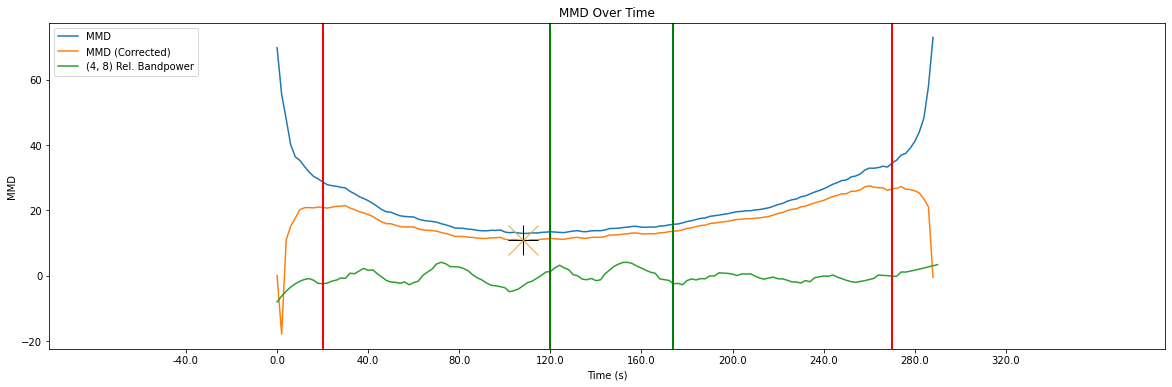

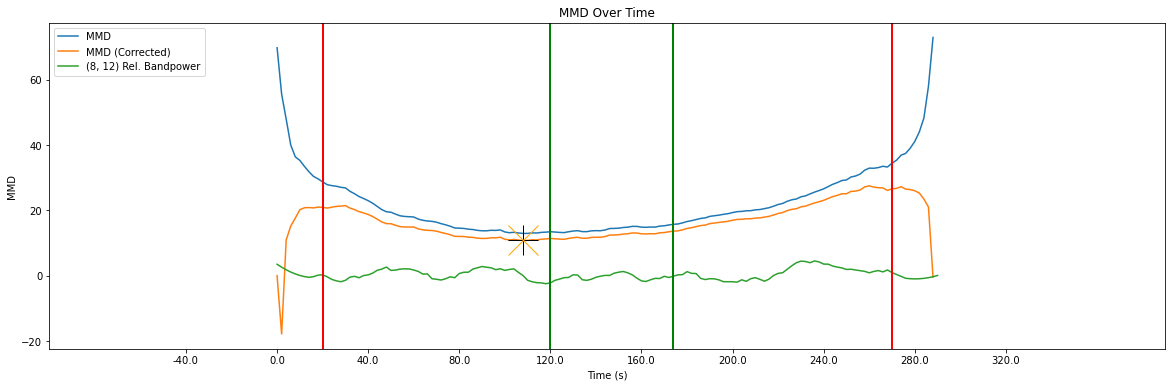

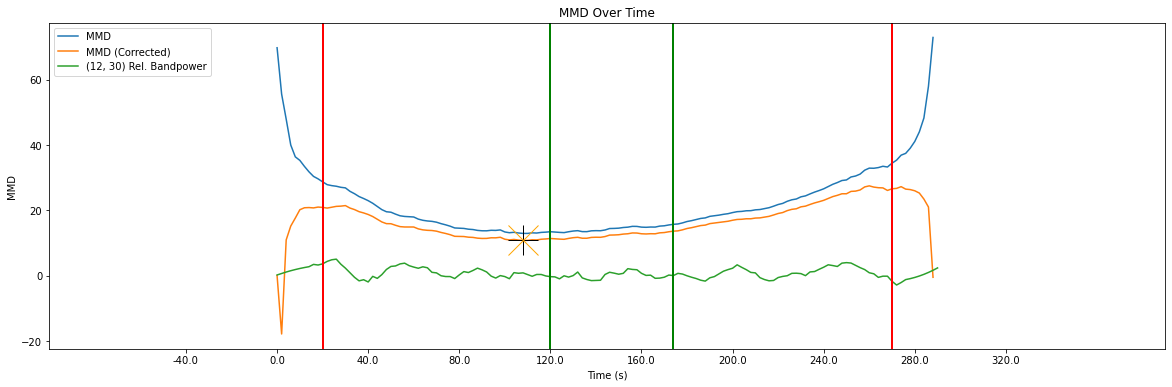

100%|██████████| 158/158 [00:00<00:00, 32109.12it/s]
/home/darylnak/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Plot 3 - Embedding Perm 3 Error: -14.0000 sec.
LR accuracy on training: 1.0
LR accuracy on downsampled training: 0.8238993710691824


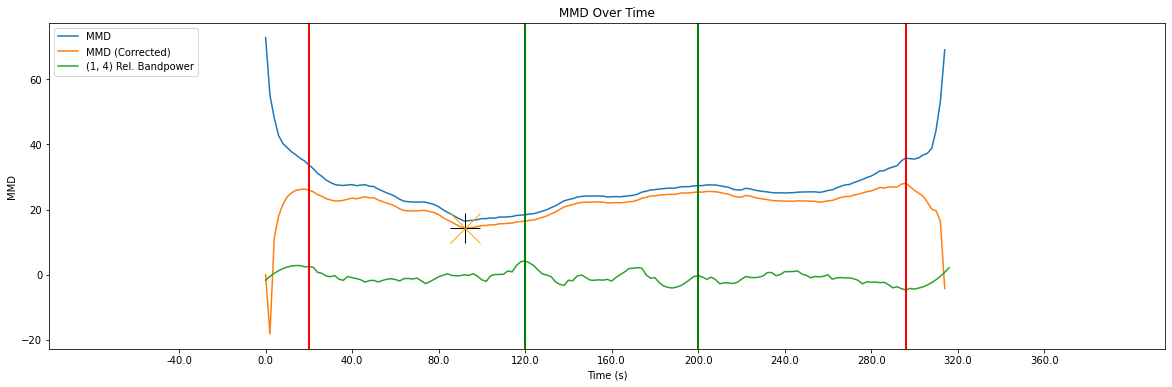

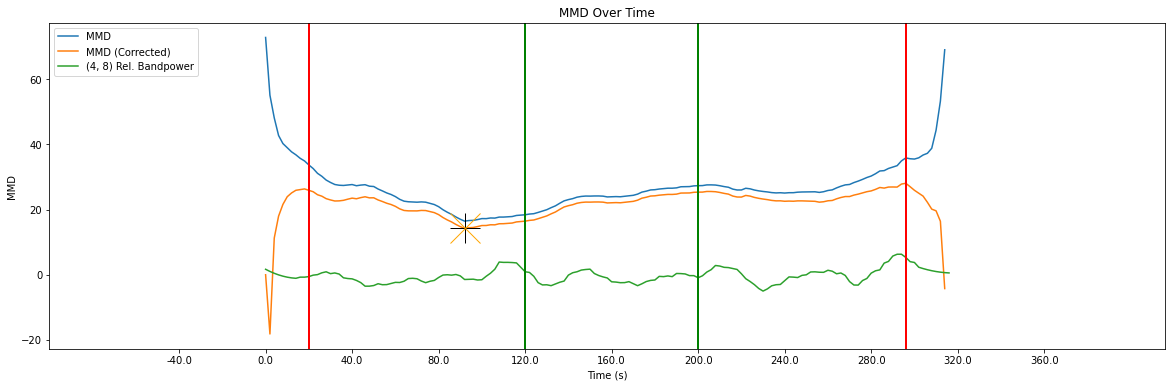

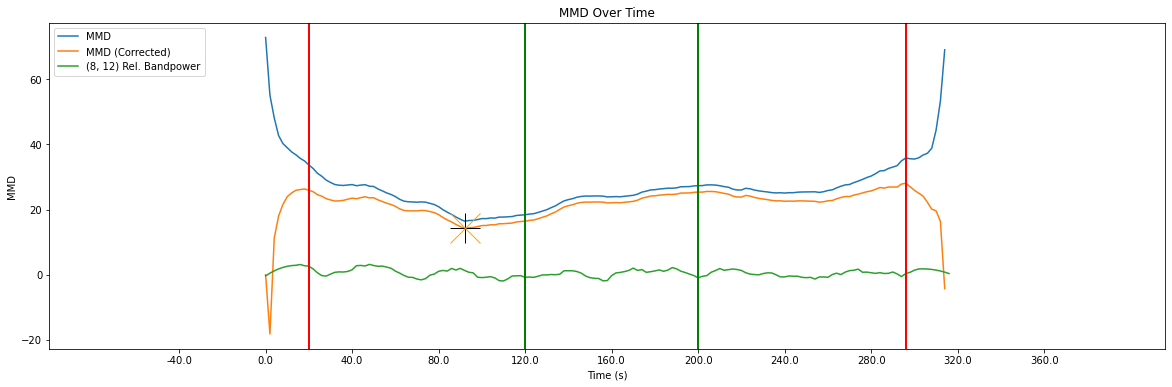

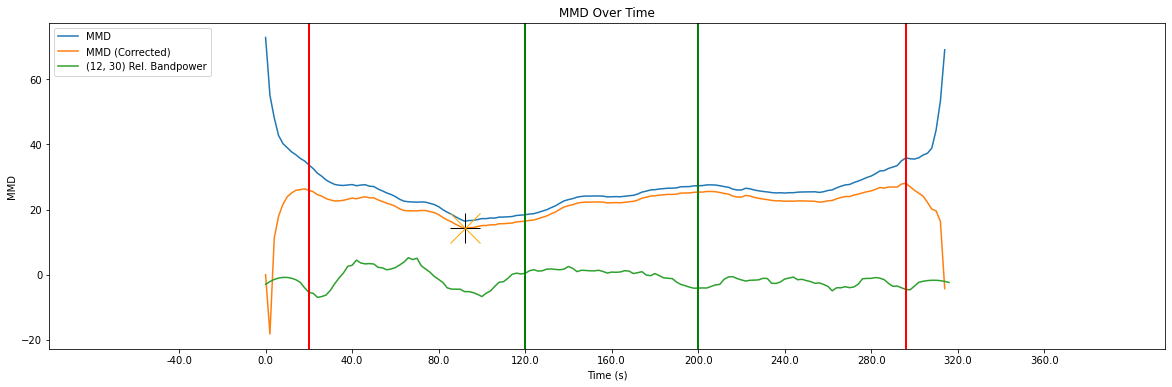

100%|██████████| 169/169 [00:00<00:00, 27589.81it/s]
/home/darylnak/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Plot 4 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 1.0
LR accuracy on downsampled training: 0.7058823529411765


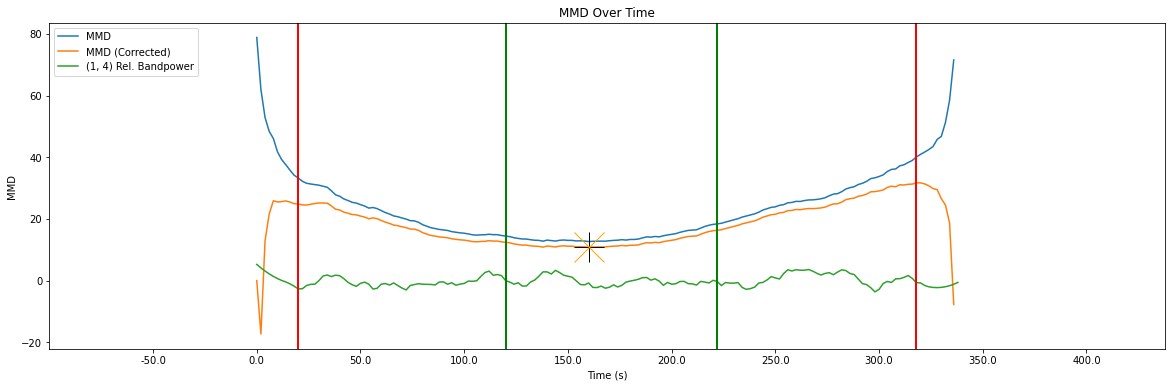

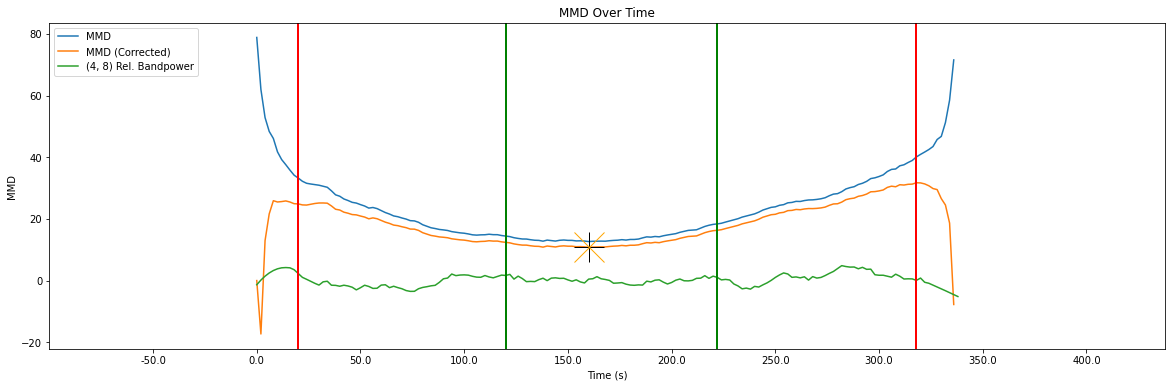

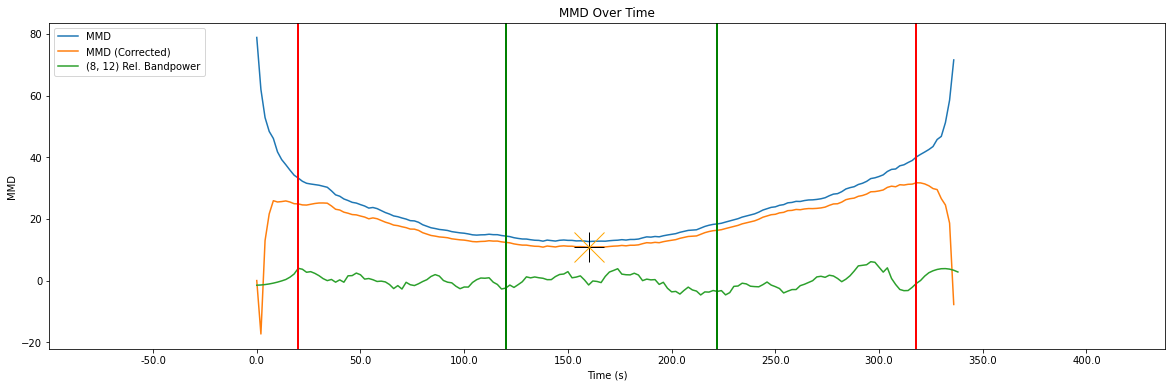

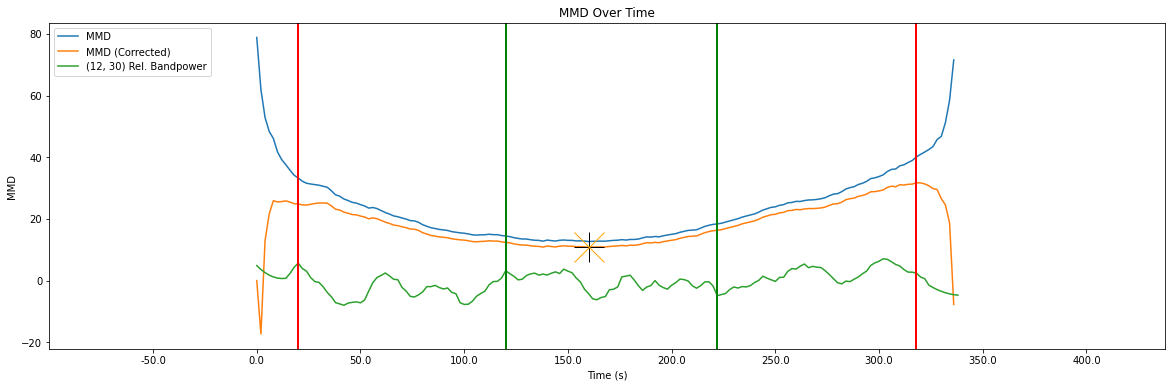

100%|██████████| 208/208 [00:00<00:00, 24279.62it/s]
/home/darylnak/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Plot 5 - Embedding Perm 3 Error: 0.0000 sec.
LR accuracy on training: 1.0
LR accuracy on downsampled training: 0.8133971291866029


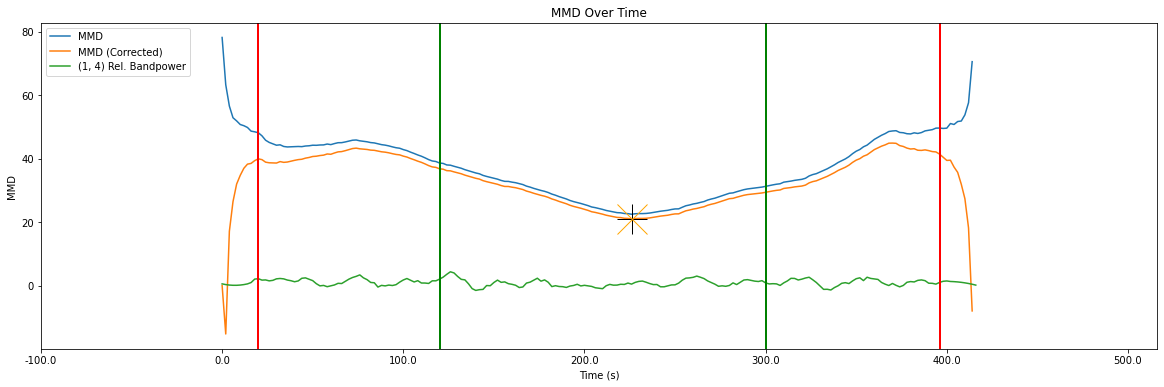

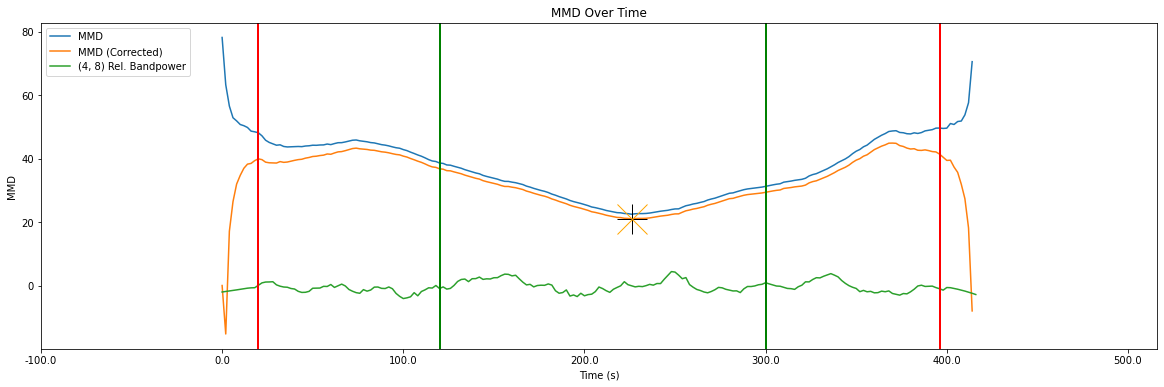

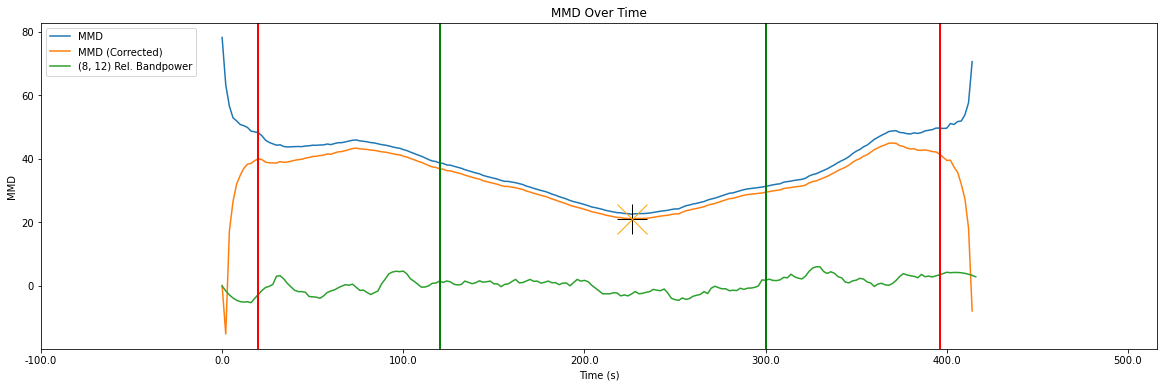

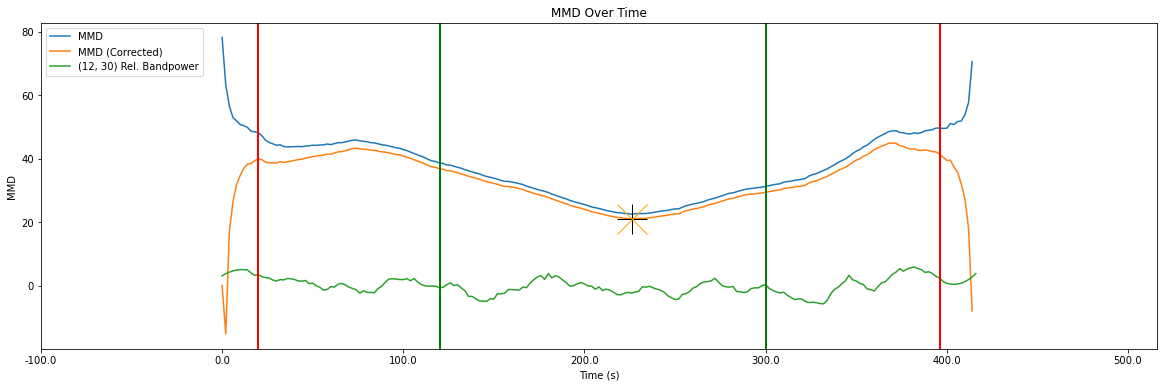

100%|██████████| 211/211 [00:00<00:00, 6292.47it/s]

Plot 6 - Embedding Perm 3 Error: 0.0000 sec.


KeyboardInterrupt: 

In [11]:
main(buff=1)

In [ ]:
main(buff=1, kernel_name="rbf")

In [ ]:
main(emb=5)

In [ ]:
main(emb=6)

In [ ]:
main(emb=7)

In [ ]:
embs = [3,4,5,6,7]
print(len(mmdaccs))
print(len(lraccs))
plt.plot(embs, mmdaccs)
plt.plot(embs, lraccs)
plt.plot(embs, lraccs_down)

In [ ]:
table = PrettyTable()
table.field_names = ["Type"] + embs
table.add_row(["MMD Accuracy"] + ["%.6f"%num for num in mmdaccs])
table.add_row(["LR Accuracy"] + ["%.6f"%num for num in lraccs])
table.add_row(["LR Accuracy (Down)"] + ["%.6f"%num for num in lraccs_down])
print(table)

Plot magnitude of coef from LR and us l1 norm penalty (small and large magnitudes)